In [0]:
# !python -m spacy download en

In [2]:
# !fusermount -u drive
# !google-drive-ocamlfuse drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import os, re, time, random
from collections import Counter
from os.path import join as joinpath
from tqdm import tqdm
tqdm.pandas()

import pandas as pd
import numpy as np

seed = 0
random.seed(seed)
np.random.seed(seed)

from nltk.stem.porter import PorterStemmer
from bs4 import BeautifulSoup
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.utils import class_weight
from sklearn.ensemble import RandomForestClassifier

from keras.models import Sequential, Model
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, GRU
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

from keras.layers import Input, Dense, TimeDistributed, Lambda
from keras.layers import Convolution1D, GlobalMaxPooling1D
from keras import callbacks  
from keras import backend as K
from keras.layers.advanced_activations import PReLU
# from keras.preprocessing import sequence, text
from tensorflow.keras.models import load_model
from keras.wrappers.scikit_learn import KerasClassifier

import matplotlib
%matplotlib inline

os.getcwd()

Using TensorFlow backend.


'/content'

In [4]:
!free -m

              total        used        free      shared  buff/cache   available
Mem:          13022         661       10420           0        1940       12102
Swap:             0           0           0


In [5]:
try:
  os.chdir('drive/My Drive/Colab Notebooks/crowdflower-search-relevance')
  print('Changed directory')
  print(os.getcwd())
except:
  print('Cannot change directory')
  print(os.getcwd())

#setting kaggle json
# !mv .kaggle/kaggle.json ~/.kaggle/kaggle.json
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle competitions submit [-h] -c crowdflower-search-relevance -f data/submission.csv -m rf
# !kaggle competitions submissions  -c crowdflower-search-relevance 

Changed directory
/content/drive/My Drive/Colab Notebooks/crowdflower-search-relevance


In [6]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
df_train.head()

,id,query,product_title,product_description,median_relevance,relevance_variance
0,1,bridal shower decorations,Accent Pillow with Heart Design - Red/Black,Red satin accent pillow embroidered with a hea...,1,0.000
1,2,led christmas lights,Set of 10 Battery Operated Multi LED Train Chr...,Set of 10 Battery Operated Train Christmas Lig...,4,0.000
2,4,projector,ViewSonic Pro8200 DLP Multimedia Projector,NaN,4,0.471
3,5,wine rack,Concept Housewares WR-44526 Solid-Wood Ceiling...,"Like a silent and sturdy tree, the Southern En...",4,0.000
4,7,light bulb,Wintergreen Lighting Christmas LED Light Bulb ...,"WTGR1011\nFeatures\nNickel base, 60,000 averag...",2,0.471


In [7]:
print(len(df_train))
print(len(df_test))

10158
22513


In [8]:
Counter(df_train.median_relevance)

Counter({1: 774, 2: 1476, 3: 1737, 4: 6171})

In [9]:
df_train.isna().sum()

id                        0
query                     0
product_title             0
product_description    2444
median_relevance          0
relevance_variance        0
dtype: int64

In [10]:
df_test.isna().sum()

id                        0
query                     0
product_title             0
product_description    5427
dtype: int64

In [11]:
Counter(df_train.median_relevance)

Counter({1: 774, 2: 1476, 3: 1737, 4: 6171})

In [12]:
# df_train = df_train.dropna()
# df_test = df_test.dropna()
# print(len(df_train))
# print(len(df_test))

df_train.fillna('', inplace=True)
df_test.fillna('', inplace=True)
df_train.head()

,id,query,product_title,product_description,median_relevance,relevance_variance
0,1,bridal shower decorations,Accent Pillow with Heart Design - Red/Black,Red satin accent pillow embroidered with a hea...,1,0.000
1,2,led christmas lights,Set of 10 Battery Operated Multi LED Train Chr...,Set of 10 Battery Operated Train Christmas Lig...,4,0.000
2,4,projector,ViewSonic Pro8200 DLP Multimedia Projector,,4,0.471
3,5,wine rack,Concept Housewares WR-44526 Solid-Wood Ceiling...,"Like a silent and sturdy tree, the Southern En...",4,0.000
4,7,light bulb,Wintergreen Lighting Christmas LED Light Bulb ...,"WTGR1011\nFeatures\nNickel base, 60,000 averag...",2,0.471


In [0]:
def remove_numbers(val):
    m = re.findall(r'([A-Za-z]\w+)', val, flags=re.I)
    return ' '.join(m)

stemmer = PorterStemmer()

def text_cleaner(x, append):
  x = BeautifulSoup(x).get_text(" ")
  x = re.sub("[^a-zA-Z0-9]", " ", x)
  x = ' '.join([stemmer.stem(w) for w in x.split()])
  if append:
    return ' '.join([append+w for w in x.split()])
  else:
    return x

In [14]:
text_cleaner('Apples a as as10 1 10 10,333', None)

'appl a as as10 1 10 10 333'

In [15]:
for col in ['query', 'product_title', 'product_description']:
  if col == 'query':
    append = 'q'
  elif col == 'product_title':
    append = 't'
  elif col == 'product_description':
    append = None
  df_train[col] = df_train[col].progress_apply(lambda x: text_cleaner(x, append))
  df_test[col] = df_test[col].progress_apply(lambda x: text_cleaner(x, append))

df_train['all_text'] = df_train[['query', 'product_title', 'product_description']].apply(lambda x: ' '.join(x), axis=1)
df_test['all_text'] = df_test[['query', 'product_title', 'product_description']].apply(lambda x: ' '.join(x), axis=1)
df_train.head()

 27%|██▋       | 2780/10158 [00:04<00:12, 612.27it/s]/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "http://i104.photobucket.com/albums/m175/champions_on_display/wincraft2013/januaryb/65497012.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
 35%|███▌      | 3568/10158 [00:05<00:11, 563.08it/s]/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "http://i104.photobucket.com/albums/m175/champions_on_display/wincraft2013/januaryb/65516012.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
 99%|█████████▉| 10051/10158 [00:15<00:00, 677.51it/s]/usr/local/lib

,id,query,product_title,product_description,median_relevance,relevance_variance,all_text
0,1,qbridal qshower qdecor,taccent tpillow twith theart tdesign tred tblack,red satin accent pillow embroid with a heart i...,1,0.000,qbridal qshower qdecor taccent tpillow twith t...
1,2,qled qchristma qlight,tset tof t10 tbatteri toper tmulti tled ttrain...,set of 10 batteri oper train christma light it...,4,0.000,qled qchristma qlight tset tof t10 tbatteri to...
2,4,qprojector,tviewson tpro8200 tdlp tmultimedia tprojector,,4,0.471,qprojector tviewson tpro8200 tdlp tmultimedia ...
3,5,qwine qrack,tconcept thousewar tWR t44526 tsolid twood tce...,like a silent and sturdi tree the southern ent...,4,0.000,qwine qrack tconcept thousewar tWR t44526 tsol...
4,7,qlight qbulb,twintergreen tlight tchristma tled tlight tbul...,wtgr1011 featur nickel base 60 000 averag hour...,2,0.471,qlight qbulb twintergreen tlight tchristma tle...


In [16]:
vocab = ' '.join(df_train['all_text'])
c = Counter(vocab.split()).most_common()
c[:100]

[('the', 22925),
 ('and', 21419),
 ('a', 13377),
 ('to', 12520),
 ('with', 10195),
 ('of', 9436),
 ('for', 8736),
 ('in', 6949),
 ('thi', 6932),
 ('your', 6517),
 ('is', 6516),
 ('you', 4828),
 ('s', 3748),
 ('or', 3643),
 ('on', 3341),
 ('that', 3077),
 ('featur', 2988),
 ('it', 2973),
 ('from', 2623),
 ('design', 2321),
 ('are', 2280),
 ('can', 2253),
 ('use', 2217),
 ('includ', 2130),
 ('inch', 2055),
 ('an', 2055),
 ('color', 2042),
 ('x', 1974),
 ('1', 1951),
 ('up', 1900),
 ('set', 1820),
 ('all', 1814),
 ('as', 1786),
 ('2', 1755),
 ('comfort', 1714),
 ('make', 1628),
 ('be', 1623),
 ('easi', 1618),
 ('5', 1606),
 ('ts', 1585),
 ('ha', 1580),
 ('style', 1558),
 ('will', 1525),
 ('3', 1508),
 ('by', 1462),
 ('It', 1457),
 ('fit', 1398),
 ('4', 1385),
 ('size', 1383),
 ('one', 1305),
 ('these', 1260),
 ('high', 1223),
 ('0', 1186),
 ('provid', 1162),
 ('made', 1155),
 ('materi', 1151),
 ('item', 1139),
 ('clean', 1127),
 ('ani', 1121),
 ('perfect', 1116),
 ('more', 1114),
 ('at', 

In [17]:
dirty = []
for w,_ in c:
  if len(w) < 4:
    dirty.append(w)
dirty[:10]

['the', 'and', 'a', 'to', 'of', 'for', 'in', 'thi', 'is', 'you']

16.26117345934239
2.424788344162237


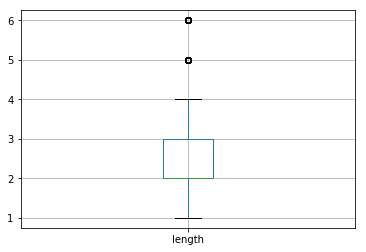

In [18]:
col = 'query'
print(df_train[col].str.len().mean())
df_train['length'] = df_train[col].apply(lambda x: len(x.split()))
print(df_train['length'].mean())
df_train.boxplot(column=['length'])

58.37802717070289
8.963378617838156


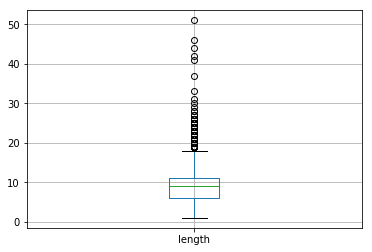

In [19]:
col = 'product_title'
print(df_train[col].str.len().mean())
df_train['length'] = df_train[col].apply(lambda x: len(x.split()))
print(df_train['length'].mean())
df_train.boxplot(column=['length'])

337.30330773774364
63.64619019492026


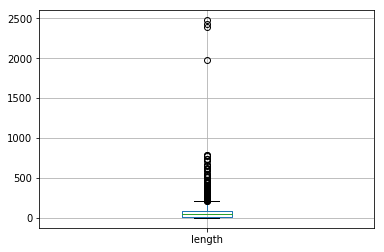

In [20]:
col = 'product_description'
print(df_train[col].str.len().mean())
df_train['length'] = df_train[col].apply(lambda x: len(x.split()))
print(df_train['length'].mean())
df_train.boxplot(column=['length'])

In [0]:
# df_train['median_relevance'] = df_train['median_relevance']/4

In [0]:
# import spacy

# nlp = spacy.load("en_core_web_sm")
# doc = nlp(' '.join(df_train.values))
# for token in doc:
#     print(token.text)

# sw = []
# stop_words = []
# stop_words = ['http','www','img','border','0','1','2','3','4','5','6','7','8','9','a','the','be','a','about','above','after','again','against','all']
# stop_words.extend(dirty)
# stop_words = text.ENGLISH_STOP_WORDS.union(stop_words)

# for stw in stop_words:
#     sw.append("q"+stw)
#     sw.append("t"+stw)

# stop_words = text.ENGLISH_STOP_WORDS.union(sw)

In [23]:
df_train.shape

(10158, 8)

In [30]:
df_negative = df_train.copy()
df_negative['query'] = np.random.permutation(df_train['query'].values)
df_negative['median_relevance'] = 1
df_negative.head()

,id,query,product_title,product_description,median_relevance,relevance_variance,all_text,length
0,1,qinfin qscarf,taccent tpillow twith theart tdesign tred tblack,red satin accent pillow embroid with a heart i...,1,0.000,qbridal qshower qdecor taccent tpillow twith t...,14
1,2,qdress qfor qwomen,tset tof t10 tbatteri toper tmulti tled ttrain...,set of 10 batteri oper train christma light it...,1,0.000,qled qchristma qlight tset tof t10 tbatteri to...,159
2,4,qaroma qdiffus,tviewson tpro8200 tdlp tmultimedia tprojector,,1,0.471,qprojector tviewson tpro8200 tdlp tmultimedia ...,0
3,5,qflower qbulb,tconcept thousewar tWR t44526 tsolid twood tce...,like a silent and sturdi tree the southern ent...,1,0.000,qwine qrack tconcept thousewar tWR t44526 tsol...,125
4,7,qrachel qray qcookwar,twintergreen tlight tchristma tled tlight tbul...,wtgr1011 featur nickel base 60 000 averag hour...,1,0.471,qlight qbulb twintergreen tlight tchristma tle...,46


In [31]:
df_train = pd.concat([df_train, df_negative], ignore_index=True, sort=False)
df_train.shape

(20316, 8)

In [35]:
Counter(df_train.median_relevance)

Counter({1: 10932, 2: 1476, 3: 1737, 4: 6171})

In [32]:
encoders = {}

encoders['tfidf'] = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}',
            ngram_range=(1, 5), use_idf=1, smooth_idf=1, 
            sublinear_tf=1, stop_words='english')

encoders['svd'] = TruncatedSVD(n_components=400, algorithm='randomized', n_iter=6, random_state=seed, tol=0.0)

encoders['scalar'] = StandardScaler(copy=True, with_mean=True, with_std=True)

encoders['y'] = OneHotEncoder()

def fit_encoders(x, y):
  print('Fitting encoders')
  x = encoders['tfidf'].fit_transform(x)
  x = encoders['svd'].fit_transform(x)
  return encoders['scalar'].fit_transform(x), encoders['y'].fit_transform(y)

def encode(x):
  print('Encoding')
  x = encoders['tfidf'].transform(x)
  x = encoders['svd'].transform(x)
  return encoders['scalar'].transform(x)

x_train, y_train = fit_encoders(df_train['all_text'], df_train['median_relevance'].values.reshape(-1, 1))
x_test = encode(df_test['all_text'])

Fitting encoders


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Encoding


In [33]:
print(x_train.shape)
print(y_train.shape)

(20316, 400)
(20316, 4)


In [34]:
def get_class_weights(y, one_hot=False):
    """Returns a dict of class weights for label encoded as well as one-hot encoded y."""
    if one_hot:
        y = np.argmax(y, axis=1)
    classes = np.unique(y)
    class_weights = class_weight.compute_class_weight('balanced', classes, y)
    return {c:w for c,w in zip(classes, class_weights)}

# class_weights = get_class_weights(s_labels)               

print('Fitting model')
def create_model():
  model = Sequential()

  model = Sequential()
  model.add(Dense(256, input_dim=x_train.shape[1]))
  model.add(BatchNormalization())
  model.add(Activation('tanh'))
  # model.add(PReLU())
  model.add(Dropout(0.5))

  model.add(Dense(256))
  model.add(BatchNormalization())
  model.add(Activation('tanh'))
  # model.add(PReLU())
  model.add(Dropout(0.5))

  model.add(Dense(y_train.shape[1], activation='softmax'))

  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  
  return model

cb_save_model = callbacks.ModelCheckpoint(joinpath('models', 'svd-nn-model.h5'),
                                                  monitor='val_acc', save_best_only=True, verbose=2)
cb_early_stopping = callbacks.EarlyStopping(monitor='val_acc', min_delta=0.001, patience=5, verbose=0, mode='auto')
all_callbacks = [cb_save_model, cb_early_stopping]

model = create_model()
model.fit(x=x_train, y=y_train, batch_size=32, epochs=100, 
             verbose=1, validation_split=0.1, shuffle=True, 
            #  class_weight=class_weights, 
             callbacks=all_callbacks)

print('Making test predictions')
model = load_model('models/svd-nn-model.h5')
t_labels = model.predict(x_test)
t_labels = [int(x) for x in encoders['y'].inverse_transform(t_labels)]
print('Done!')

df_test['prediction'] = t_labels

submission_file_path = 'data/submission.csv'
df_test[['id', 'prediction']].to_csv(submission_file_path, index=False)
print('Submission saved!')

Fitting model




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 18284 samples, validate on 2032 samples
Epoch 1/100





18284/18284 [==============================] - 5s 292us/step - loss: 1.3250 - acc: 0.4047 - val_loss: 0.7075 - val_acc: 0.7943

Epoch 00001: val_acc improved from -inf to 0.79429, saving model to models/svd-nn-model.h5
Epoch 2/100
18284/18284 [==============================] - 4s 220us/step - loss: 1.1524 - acc: 0.4589 - val_loss: 0.7081 - val_acc: 0.8219

Epoch 00002: val_acc improved from 0.79429 to 0.82185, saving model to models/svd-nn-model.h5
Epoch 3/100
18284/18284 [==============================] - 4s 218us/step - loss: 1.1171 - acc: 0.4752 - val_loss: 0.7721 - val_acc: 0.7047

Epoch 00003: val_acc did not improve from 0.82185
Epoch 4/100
18284/18284 [==============================] - 